# Task 1 - CNN Model

---
## Import

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, losses, Input
from keras_tuner import RandomSearch, Objective
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import sys
sys.path.append('../')

from utils.tensorflow_preprocessing import prepare_image_target_dataset

In [2]:
%store -r train_X
%store -r val_X
%store -r test_X

---
## Prepare dataset

In [3]:
# TODO: REMOVE
frac = 0.001
train_X = train_X.sample(frac=frac, random_state=42)
val_X = val_X.sample(frac=frac, random_state=42)
test_X = test_X.sample(frac=frac, random_state=42)

In [23]:
train_class_ds, class_encoder = prepare_image_target_dataset(train_X, target_name="Class")
val_class_ds, _ = prepare_image_target_dataset(val_X, target_name="Class", label_encoder=class_encoder)
test_class_ds, _ = prepare_image_target_dataset(test_X, target_name="Class", label_encoder=class_encoder)

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_class_ds = train_class_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_class_ds = val_class_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_class_ds = test_class_ds.cache().prefetch(buffer_size=AUTOTUNE)

---
## Model training

In [6]:
# Basic Model Training
def create_model():
    this_model = models.Sequential([
        Input(shape=(256, 256, 3)),
        layers.Conv2D(4, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(8, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (4, 4), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (4, 4), activation='relu'),
        layers.GlobalMaxPooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5, seed=21),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5, seed=42),
        layers.Dense(128, activation='sigmoid'),
        layers.Dense(6, activation='softmax')
    ])

    this_model.compile(optimizer='adam',
                  loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return this_model


In [7]:
# Train the model
basic_model = create_model()
epochs = 10
history = basic_model.fit(train_class_ds, epochs=epochs, batch_size=32, validation_data=test_class_ds)

Epoch 1/10


2024-05-14 16:18:50.769507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 423ms/step - loss: 2.2679 - accuracy: 0.0556 - val_loss: 2.0830 - val_accuracy: 0.1111
Epoch 2/10
2/2 [==============================] - 0s 43ms/step - loss: 2.0863 - accuracy: 0.0556 - val_loss: 1.9577 - val_accuracy: 0.1111
Epoch 3/10
2/2 [==============================] - 0s 50ms/step - loss: 1.8880 - accuracy: 0.0741 - val_loss: 1.8245 - val_accuracy: 0.2778
Epoch 4/10
2/2 [==============================] - 0s 57ms/step - loss: 1.6800 - accuracy: 0.2037 - val_loss: 1.6970 - val_accuracy: 0.1667
Epoch 5/10
2/2 [==============================] - 0s 50ms/step - loss: 1.4821 - accuracy: 0.3148 - val_loss: 1.6683 - val_accuracy: 0.3889
Epoch 6/10
2/2 [==============================] - 0s 42ms/step - loss: 1.3653 - accuracy: 0.4630 - val_loss: 1.8030 - val_accuracy: 0.3889
Epoch 7/10
2/2 [==============================] - 0s 53ms/step - loss: 1.2829 - accuracy: 0.5000 - val_loss: 1.9817 - val_accuracy: 0.3889
Epoch 8/10
2/2 [=====================

In [8]:
# Evaluate the model
test_loss, test_accuracy = basic_model.evaluate(test_class_ds)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

1/1 [==============================] - 0s 13ms/step - loss: 2.2967 - accuracy: 0.1667
Test Loss: 2.2967
Test Accuracy: 0.1667


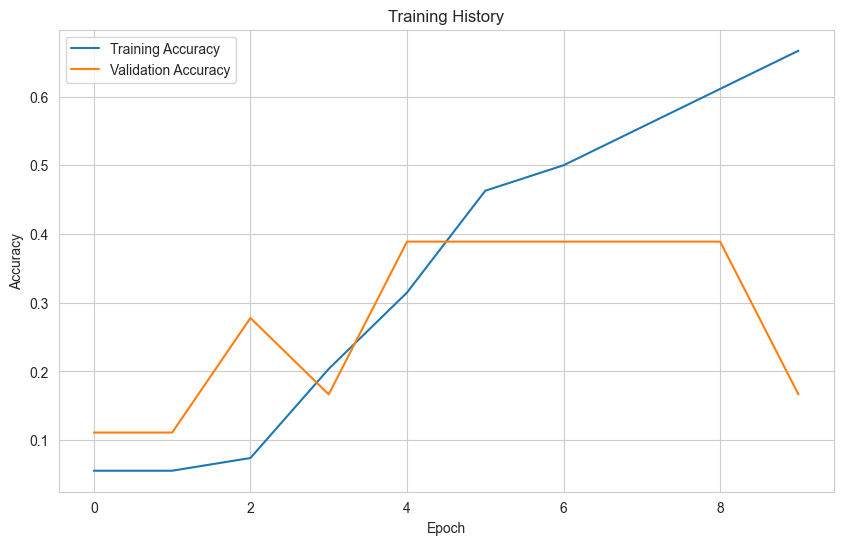

In [9]:
# Visualize the training history of the basic model
def plot_training_history(hist):
    plt.figure(figsize=(10, 6))
    plt.plot(hist.history['accuracy'], label='Training Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training History')
    plt.show()

plot_training_history(history)

---
## Optimization

In [10]:
# Hyperparameter Tuning
def build_model(hp):
    this_model = models.Sequential([
        Input(shape=(256, 256, 3)),
        layers.Conv2D(4, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(8, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (4, 4), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (4, 4), activation='relu'),
        layers.GlobalMaxPooling2D(),
        layers.Dense(hp.Choice('dense1_units', [64, 128]), activation='relu'),
        layers.Dropout(hp.Choice('dropout1_rate', [0.3, 0.5])),
        layers.Dense(hp.Choice('dense2_units', [64, 128]), activation='relu'),
        layers.Dropout(hp.Choice('dropout2_rate', [0.3, 0.5])),
        layers.Dense(128, activation='sigmoid'),
        layers.Dense(6, activation='softmax')
    ])

    this_model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return this_model

In [11]:
tuner = RandomSearch(
    build_model,
    objective=Objective('val_accuracy', direction='max'),
    max_trials=4,
    executions_per_trial=1,
    directory='../data/tuner_results',
    project_name='task_1_CNN'
)

Reloading Tuner from ../data/tuner_results/task_1_CNN/tuner0.json


In [12]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
dense1_units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
dropout1_rate (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.5], 'ordered': True}
dense2_units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
dropout2_rate (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.5], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop'], 'ordered': False}


In [13]:
tuner.search(train_class_ds,
             epochs=5,
             validation_data=val_class_ds)

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [14]:
# Evaluate the best model
tuned_test_loss, tuned_test_accuracy = best_model.evaluate(test_class_ds)
print(f'Best Model Test Loss: {tuned_test_loss:.4f}')
print(f'Best Model Test Accuracy: {tuned_test_accuracy:.4f}')

1/1 [==============================] - 0s 176ms/step - loss: 1.7514 - accuracy: 0.3889
Best Model Test Loss: 1.7514
Best Model Test Accuracy: 0.3889


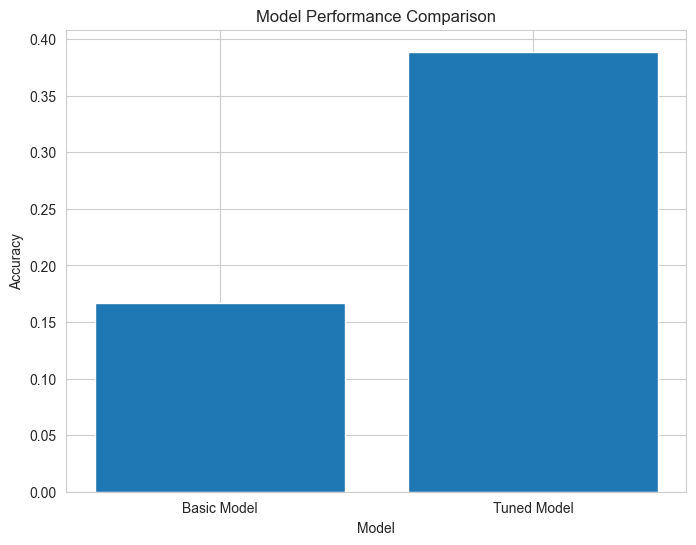

1/1 [==============================] - 0s 88ms/step


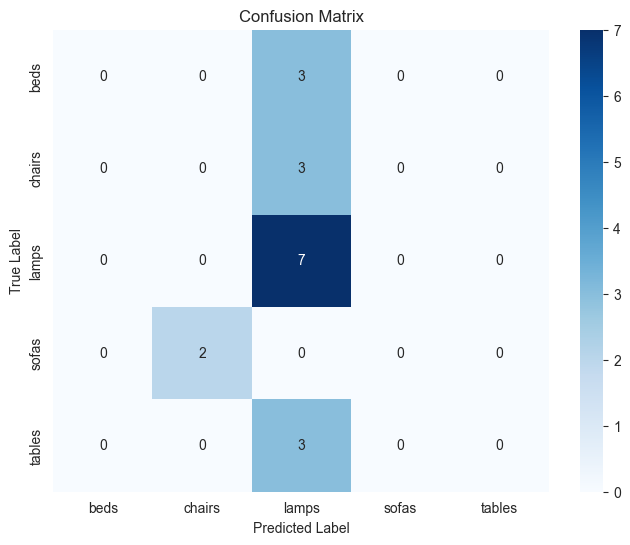

In [15]:
# Compare the performance of the basic model and the best model
model_labels = ['Basic Model', 'Tuned Model']
accuracies = [test_accuracy, tuned_test_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(model_labels, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.show()

# Visualize the confusion matrix
def plot_confusion_matrix(model, test_data, label_encoder):
    y_true = []
    y_pred = []
    for images, labels in test_data:
        y_true.extend(labels.numpy())
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

    cm = confusion_matrix(y_true, y_pred)

    # Get the decoded class labels
    class_labels = label_encoder.inverse_transform(np.unique(y_true))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
plot_confusion_matrix(best_model, test_class_ds,class_encoder)

---
## Testing

1/1 [==============================] - 0s 15ms/step


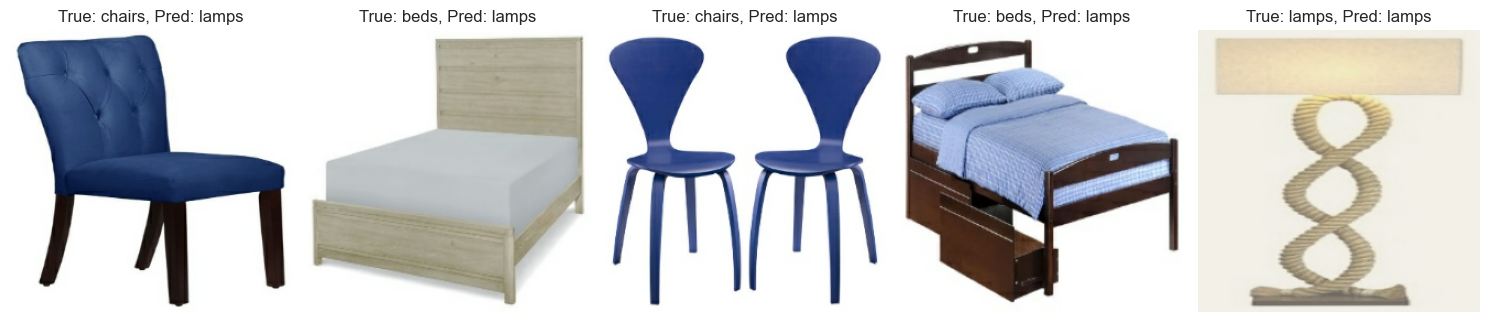

In [16]:
def visualize_predictions(model, test_data, label_encoder, num_samples=5):
    for images, labels in test_data.take(1):
        predictions = model.predict(images)
        predicted_labels = np.argmax(predictions, axis=1)

        plt.figure(figsize=(15, 12))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i+1)
            plt.imshow((images[i].numpy() * 255).astype('uint8'))
            true_label = label_encoder.inverse_transform([labels[i]])[0]
            pred_label = label_encoder.inverse_transform([predicted_labels[i]])[0]
            plt.title(f"True: {true_label}, Pred: {pred_label}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

visualize_predictions(best_model, test_class_ds, class_encoder)

---
## Save

In [17]:
from pathlib import Path

# Create paths
model_path = '../data/models'
processed_model_dir = Path(model_path)
processed_model_dir.mkdir(parents=True, exist_ok=True)

best_model.save(model_path + '/' + 'task-1-CNN.keras')

In [24]:
encoder_path = '../data/label_encoders'
label_encoder_dir = Path(encoder_path)
label_encoder_dir.mkdir(parents=True, exist_ok=True)

np.save(encoder_path + "/" + 'class_encoder.npy', class_encoder.classes_)